# **Trabajo Práctico N°1 : Reservas de Hotel**

**Checkpoint 3**

Grupo: N°06 - Pandatos

Integrantes: 
* Juan Sebastian Makkos 
* Valeria Brzoza 
* Rodolfo Valentin Albornoz Tomé


Importamos las librerias correspondientes que vamos a utilizar

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import xgboost as xgb
import pydotplus
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn import tree
from collections import defaultdict
from six import StringIO

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('always')

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


Cargamos el dataset de hotels_train y de hotels_test


In [ ]:
ds_hotels_train = pd.read_csv('/content/drive/MyDrive/TP1_Orga/ds_trabajo_procesado.csv')
ds_trabajo = ds_hotels_train.copy()
ds_hotels_test = pd.read_csv('/content/drive/MyDrive/TP1_Orga/hotels_test.csv')
ds_test = ds_hotels_test.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Sacamos del dataset de test las columnas eliminadas en el dataset de trabajo debido al análisis exploratorio

In [ ]:
ds_test = ds_test[['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'total_of_special_requests', 'id']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Guardamos una copia de la columna id del dataset de test y luego la eliminamos del mismo dataset para evitar errores

In [ ]:
ds_test_id = ds_test['id'].copy()
ds_test = ds_test.drop(['id'], axis = 'columns', inplace = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Eliminamos las columnas Unnamed: 0 y id ya que no los necesitamos en el dataset de train

In [ ]:
ds_trabajo = ds_trabajo.drop(['Unnamed: 0'], axis = 'columns', inplace = False)
ds_trabajo = ds_trabajo.drop(['id'], axis = 'columns', inplace = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Categorizamos todas las variables categoricas con label encoder tanto en el dataset de test como el de train

In [ ]:
variables_categoricas = ['hotel', 'arrival_date_year', 'arrival_date_month', 
                         'arrival_date_day_of_month', 'meal', 'country',
                         'is_repeated_guest', 'reserved_room_type', 
                         'assigned_room_type', 'deposit_type', 'agent', 
                         'customer_type']

label_encoder = preprocessing.LabelEncoder()

for columna in ds_trabajo.columns:
  if columna in variables_categoricas:
    ds_trabajo[columna] = label_encoder.fit_transform(ds_trabajo[columna]) 
for columna in ds_test.columns:
  if columna in variables_categoricas:
    ds_test[columna] = label_encoder.fit_transform(ds_test[columna])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Manipulamos el dataset de trabajo para poder separarlo en 2 partes, un dataset con el atributo a predecir, y un dataset con el resto de atributos

In [ ]:
target = 'is_canceled'

ds_trabajo_x = ds_trabajo.drop([target], axis = 'columns', inplace = False)
ds_trabajo_y = ds_trabajo[target].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **K-Nearest Neighbors (KNN)**

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split(ds_trabajo_x, ds_trabajo_y, 
                                                                    test_size = 0.30, random_state = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimización de hiperparámetros

Optimizamos los parámetros usando random search cross validation

In [ ]:
params_grid = {'n_neighbors' : range(1, 10), 
              'weights' : ['distance','uniform'],
              'algorithm' : ['ball_tree', 'brute'],
              'metric' : ['euclidean']}

scorer_fn = make_scorer(sk.metrics.f1_score)

knn = KNeighborsClassifier()

rand_knn = RandomizedSearchCV(knn, params_grid, cv = 5, scoring = scorer_fn, 
                              n_iter = 10, random_state = 5)

rand_knn.fit(x_train_knn, y_train_knn)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'brute'],
                                        'metric': ['euclidean'],
                                        'n_neighbors': range(1, 10),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, scoring=make_scorer(f1_score))

Imprimimos los mejores hiperparámetros y la mejor métrica

In [ ]:
print("Mejores parámetros: " + str(rand_knn.best_params_))
print("Mejor métrica: " + str(rand_knn.best_score_))
rand_knn.cv_results_['mean_test_score']

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Mejor métrica: 0.7756631962287595


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.75377644, 0.7708251 , 0.72188892, 0.76019541, 0.7607437 ,
       0.75989598, 0.76046634, 0.76019541, 0.75985816, 0.7756632 ])

Imprimimos el mejor estimador

In [ ]:
print("Mejor estimador: " + str(rand_knn.best_estimator_))

Mejor estimador: KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=6,
                     weights='distance')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creación del modelo y predicción

Creamos un clasificador KNN con los hiperparámetros optimizados

In [ ]:
KNN_Classifier = KNeighborsClassifier(weights = 'distance', n_neighbors = 30, 
                                      metric = 'euclidean', algorithm = 'ball_tree')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entrenamos el modelo y realizamos una predicción sobre el set de test

In [ ]:
model_knn = KNN_Classifier.fit(x_train_knn, y_train_knn)
y_pred_knn = KNN_Classifier.predict(x_test_knn)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Support Vector Machines (SVM)**

### Creación del modelo y predicción

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(ds_trabajo_x, 
                                                                    ds_trabajo_y, 
                                                                    test_size = 0.3,  
                                                                    random_state = 109)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Modelo con datos estandarizados

Armamos la versión del modelo con los datos estandarizados

In [ ]:
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train_svm)
x_test_norm = stand_scaler.transform(x_test_svm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Construimos el modelo, lo entrenamos con los datos escalados con normalización y realizamos una predicción

In [ ]:
svm_norm = SVC()

model_svm_norm = svm_norm.fit(x_train_norm, y_train_svm)

y_pred_svm_norm = model_svm_norm.predict(x_test_norm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Modelo con datos escalados con min max

Armamos la versión del modelo con los datos escalados con min max

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train_svm) 
x_test_minmax  = min_max_scaler.transform(x_test_svm) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Construimos el modelo, lo entrenamos con los datos escalados con min max y realizamos una predicción

In [ ]:
svm_minmax = SVC()

model_svm_minmax = svm_minmax.fit(x_train_minmax, y_train_svm)

y_pred_svm_minmax = model_svm_minmax.predict(x_test_minmax)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Modelo con Kernel lineal

Se arma la versión del modelo creando un clasificador con kernel lineal y entrenandolo sobre los datos escalados con min-max


In [ ]:
svm_lineal = SVC(kernel = 'linear', C = 5)
svm_lineal.fit(x_train_minmax, y_train_svm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SVC(C=5, kernel='linear')

Realizamos la predicción

In [ ]:
y_pred_lin = svm_lineal.predict(x_test_minmax)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Modelo con Kernel polinómico

Se arma la versión del modelo creando un clasificador con kernel polinómico y entrenandolo sobre los datos escalados con min-max

In [ ]:
svm_polinomico = SVC(kernel = 'poly', C = 0.1, degree = 2, gamma = 5, coef0 = 10)
svm_polinomico.fit(x_train_minmax, y_train_svm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SVC(C=0.1, coef0=10, degree=2, gamma=5, kernel='poly')

Realizamos la predicción

In [ ]:
y_pred_pol = svm_polinomico.predict(x_test_minmax)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Modelo con Kernel radial

Se arma la versión del modelo creando un clasificador con kernel radial y entrenandolo sobre los datos escalados con min-max

In [ ]:
svm_radial = SVC(kernel = 'rbf', C = 0.1, degree = 2, gamma = 5, coef0 = 10)
svm_radial.fit(x_train_minmax, y_train_svm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SVC(C=0.1, coef0=10, degree=2, gamma=5)

Realizamos la predicción

In [ ]:
y_pred_rad = svm_radial.predict(x_test_minmax)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### PCA

Realizamos PCA sobre los datos escalados y creamos una variable con la cantidad de componentes

In [ ]:
pca = PCA(n_components = None)
pca.fit(x_train_norm)

componentes = len(pca.explained_variance_ratio_) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Graficamos la varianza explicada

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Varianza Explicada (%)')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

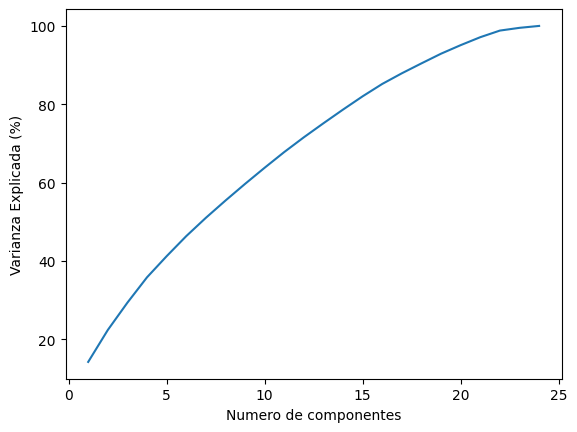

In [ ]:
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

Del gráfico, se puede ver que con las primeras 20 componentes principales, se explica aproximadamente el 90% de la variabilidad de los datos.

Se entrena un SVM con solo las primeras 20 componentes, definiendo el tipo de escalado, la transformación PCA y el modelo

In [ ]:
_sc = StandardScaler()
_pca = PCA(n_components = 20)
_model = SVC()

svm_model_pc = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Se entrena sobre los datos que serán previamente escalados y transformados, y se realiza la predicción

In [ ]:
svm_model_pc.fit(x_train_svm, y_train_svm)

y_pred_pca = svm_model_pc.predict(x_test_svm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Random Forest (RF)**

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(ds_trabajo_x, 
                                                                ds_trabajo_y, 
                                                                test_size = 0.3,  
                                                                random_state = 109)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimización de hiperparámetros

Optimizamos los parámetros usando random search cross validation

In [ ]:
from scipy.stats import randint

rf = RandomForestClassifier()

param_dist = {'n_estimators': randint(100, 500),
              'max_depth': [10, 20, 30],
              'min_samples_split': [2, 10],
              'min_samples_leaf': [1, 10],
              'bootstrap': [True],
              'criterion': ['gini', 'entropy']}

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

scorer_fn = make_scorer(f1_score)

random_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 10, 
                                   cv = kfold, scoring = scorer_fn)

random_search.fit(x_train_rf, y_train_rf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 10],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd8cdceb880>},
                   scoring=make_scorer(f1_score))

## Creación del modelo y predicción

Entrenamos el mejor modelo y realizamos una predicción sobre el set de test

In [ ]:
mejor_modelo_rf = random_search.best_estimator_

y_pred_rf = mejor_modelo_rf.predict(x_test_rf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **XGBoost**

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = train_test_split(ds_trabajo_x, 
                                                                    ds_trabajo_y,
                                                                    test_size = 0.3,  
                                                                    random_state = 109)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimización de hiperparámetros

Se ponen los datos de entrenamiento en formato DMatrix

In [ ]:
data_dmatrix = xgb.DMatrix(data = x_train_xgb, label = y_train_xgb)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Se entrena con CV

In [ ]:
results = xgb.cv(dtrain = data_dmatrix, nfold = 5, params = {'learning_rate': 0.1}, num_boost_round = 8, metrics = 'auc', seed = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creación del modelo y predicción

Se crea el modelo y se realiza una predicción

In [ ]:
xgb_model = xgb.XGBClassifier(random_state = 0, n_estimators = 150)
xgb_model.fit(x_train_xgb, y_train_xgb)

y_pred_xgb = xgb_model.predict_proba(x_test_xgb)[:, 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Ensamble híbrido tipo Voting**

### Creación del modelo y predicción

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train_voting, x_test_voting, y_train_voting, y_test_voting = train_test_split(ds_trabajo_x, ds_trabajo_y, random_state = 42, train_size = 0.70)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Construimos el ensamble hibrido, creando clasificadores, el ensamble de votación, entrenandolo y haciendo una predicción

In [ ]:
from xgboost.sklearn import XGBClassifier

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier()

vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('xgb', xgb_clf), ('knn', knn_clf)], voting='hard')

model_voting = vot_clf.fit(x_train_voting, y_train_voting)

y_pred_voting = vot_clf.predict(x_test_voting)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Ensamble híbrido tipo Stacking**

### Creación del modelo y predicción

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train_stacking, x_test_stacking, y_train_stacking, y_test_stacking = train_test_split(ds_trabajo_x, ds_trabajo_y, random_state = 42, train_size = 0.70)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creamos el ensamble hibrido definiendo los modelos base y el metamodelo

In [ ]:
base_models = [('random_forest', RandomForestClassifier(n_estimators = 50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors = 11))]

metamodelo = LogisticRegressionCV()

stacking_model = StackingClassifier(estimators = base_models, 
                                    final_estimator = metamodelo, 
                                    passthrough = True, 
                                    cv = 5,
                                    verbose = 2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entrenamos el ensable Stacking y sacamos la prediccion

In [ ]:
stacking_model.fit(x_train_stacking, y_train_stacking)
y_pred_stacking = stacking_model.predict(x_test_stacking)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: 

# **Performance de los modelos**

Creamos la función para plotear la matriz de confusión

In [ ]:
def matriz_de_confusion(y_test, y_pred):

  tabla = confusion_matrix(y_test, y_pred)

  sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creamos la función para imprimir las métricas en el conjunto de evaluación

In [ ]:
def metricas_evaluacion(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("Accuracy: "+ str(accuracy))
  print("Recall: "+ str(recall))
  print("f1 score: "+ str(f1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creamos la función para mostrar el reporte del valor de las métricas para el conjunto de test

In [ ]:
def valor_metricas_test(y_test, y_pred):
  print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor de las métricas para el conjunto de training

In [ ]:
def valor_metricas_train(y_train, x_train, modelo):
  print(classification_report(y_train, modelo.predict(x_train)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **KNN**

Matriz de confusion del modelo KNN

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


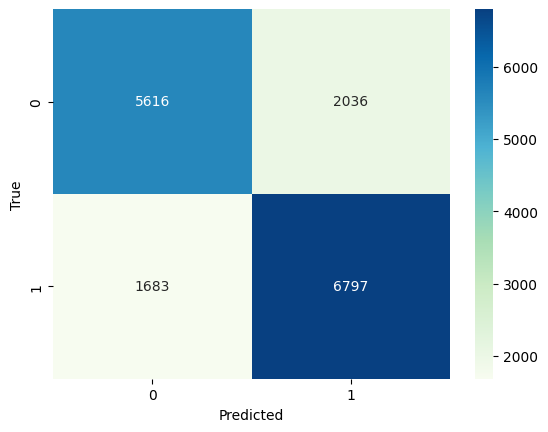

In [ ]:
matriz_de_confusion(y_test_knn, y_pred_knn)

Métricas en el conjunto de evaluación del modelo KNN

In [ ]:
metricas_evaluacion(y_test_knn, y_pred_knn)

Accuracy: 0.7694644185469873
Recall: 0.8015330188679245
f1 score: 0.7851903194131578


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de test del modelo KNN

In [ ]:
valor_metricas_test(y_test_knn, y_pred_knn)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      7652
           1       0.77      0.80      0.79      8480

    accuracy                           0.77     16132
   macro avg       0.77      0.77      0.77     16132
weighted avg       0.77      0.77      0.77     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de train del modelo KNN

In [ ]:
valor_metricas_train(y_train_knn, x_train_knn, model_knn)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18078
           1       1.00      1.00      1.00     19561

    accuracy                           1.00     37639
   macro avg       1.00      1.00      1.00     37639
weighted avg       1.00      1.00      1.00     37639



Viendo el valor de las metricas y con la matriz de confusion, podemos decir que entre los labels 0 y 1, no hay una diferencia significativa entre ambos, pero si difieren entre el set test y el set train.

Tambien coincide que en ambos casos, el label 1 es el que tiene mayor valor para recall y f1-score, y coincide con la mayor cantidad de registros con este label.

Por ultimo, como podemos observar, el f1-score en datos de entrenamiento es aproximadamente un 25% mas alto que con datos de test, esto indica que el modelo podria estar overfiteado.

## **SVM**

En este caso, utilizamos el modelo SVM al cual se le realizó PCA

Matriz de confusion del modelo SVM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


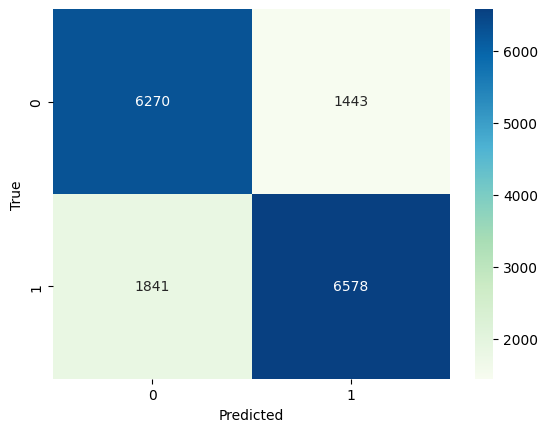

In [ ]:
matriz_de_confusion(y_test_svm, y_pred_pca) 

Métricas en el conjunto de evaluación del modelo SVM

In [ ]:
metricas_evaluacion(y_test_svm, y_pred_pca)

Accuracy: 0.7964294569799157
Recall: 0.7813279486874926
f1 score: 0.8002433090024329


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de test del modelo SVM

In [ ]:
valor_metricas_test(y_test_svm, y_pred_pca)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      7713
           1       0.82      0.78      0.80      8419

    accuracy                           0.80     16132
   macro avg       0.80      0.80      0.80     16132
weighted avg       0.80      0.80      0.80     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de train del modelo SVM

In [ ]:
valor_metricas_train(y_train_svm, x_train_svm, svm_model_pc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.79      0.83      0.81     18017
           1       0.84      0.80      0.82     19622

    accuracy                           0.81     37639
   macro avg       0.81      0.81      0.81     37639
weighted avg       0.81      0.81      0.81     37639



Visualizando ambas metricas y con la matriz de confusion, podemos concluir que entre los label 0 y 1, no hay una clara diferencia tan grande entre ambos.

Tambien coincide que en ambos casos, el label 1 es el que tiene mayor valor para precision y f1 score, con la mayor cantidad de registros en este label. Pero observamos que para el label 0, en ambos casos, el recall tiene mayor valor.

Por ultimo, como podemos observar, el f1-score en ambos casos, son muy similares, con lo cual nos da indicio que el modelo no esta overfiteado

## **RF**

Matriz de confusion del modelo Random Forest

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


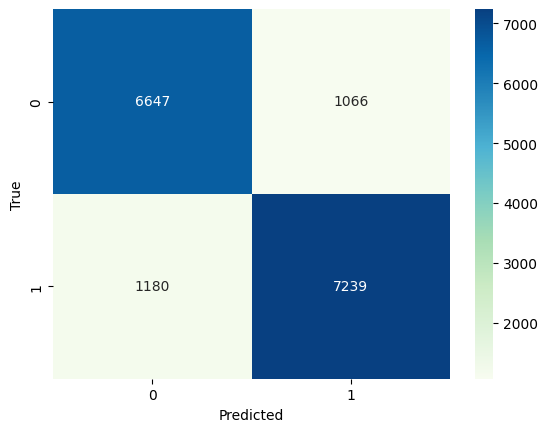

In [ ]:
matriz_de_confusion(y_test_rf, y_pred_rf)

Métricas en el conjunto de evaluación del modelo Random Forest

In [ ]:
metricas_evaluacion(y_test_rf, y_pred_rf)

Accuracy: 0.8607736176543516
Recall: 0.8598408362038247
f1 score: 0.8657019851710118


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de test del modelo Random Forest

In [ ]:
valor_metricas_test(y_test_rf, y_pred_rf)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      7713
           1       0.87      0.86      0.87      8419

    accuracy                           0.86     16132
   macro avg       0.86      0.86      0.86     16132
weighted avg       0.86      0.86      0.86     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de train del modelo Random Forest

In [ ]:
valor_metricas_train(y_train_rf, x_train_rf, mejor_modelo_rf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.96      0.95      0.96     18017
           1       0.96      0.96      0.96     19622

    accuracy                           0.96     37639
   macro avg       0.96      0.96      0.96     37639
weighted avg       0.96      0.96      0.96     37639



Viendo el valor de ambas metricas, y con la matriz de confusion, podemos decir que entre los labels 0 y 1, la diferencia es bastante baja pero si difieren entre ambos casos.

Tambien podemos ver que con que con el set test, en el label 1, las metricas son todas iguales, y coincide con la mayor cantidad de registros.

Por ultimo, como podemos observar, el f1-score en datos de entrenamiento es aproximadamente un 15% mas alto que con datos de test, esto indica que el modelo podria estar overfiteado

Importancia de Gini del modelo del mejor arbol

In [ ]:
sorted(list(zip(ds_trabajo_x.columns.to_list(), mejor_modelo_rf.feature_importances_)), key = lambda x: -x[1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('country', 0.12452005446931393),
 ('lead_time', 0.1236816003760162),
 ('deposit_type', 0.11240122076036028),
 ('agent', 0.10605140478189173),
 ('adr', 0.0845688907195949),
 ('total_of_special_requests', 0.06190670672466412),
 ('arrival_date_day_of_month', 0.05166713334626913),
 ('customer_type', 0.042025154678504095),
 ('previous_cancellations', 0.03989393642202673),
 ('arrival_date_month', 0.03858202690725749),
 ('stays_in_week_nights', 0.03348146688221177),
 ('arrival_date_year', 0.03335124685958298),
 ('assigned_room_type', 0.028619104963312804),
 ('booking_changes', 0.023127311178077356),
 ('stays_in_weekend_nights', 0.020583030360095317),
 ('reserved_room_type', 0.018321030559884977),
 ('meal', 0.015145976624789932),
 ('adults', 0.012621622565875507),
 ('hotel', 0.011780556070840475),
 ('children', 0.007344837963998487),
 ('days_in_waiting_list', 0.004165284012811267),
 ('previous_bookings_not_canceled', 0.003076094552771073),
 ('is_repeated_guest', 0.0020069141402672807),
 ('ba

Podemos concluir que los atributos con mayor importancia son lead_time, country y deposit_type.

## **XGBoost**

Matriz de confusion del modelo XGBoost

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


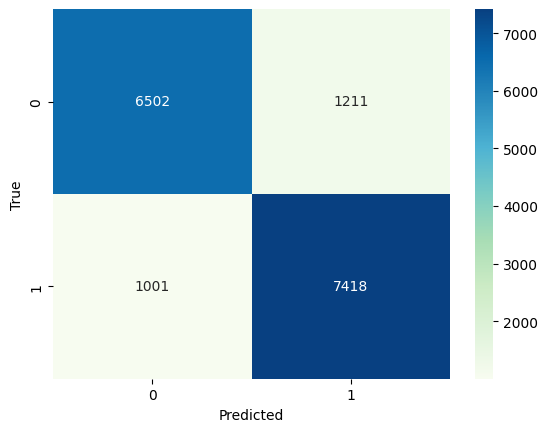

In [ ]:
matriz_de_confusion(y_test_xgb, y_pred_xgb.round())

Métricas en el conjunto de evaluación del modelo XGBoost



In [ ]:
metricas_evaluacion(y_test_xgb, y_pred_xgb.round())

Accuracy: 0.862881229853707
Recall: 0.8811022686779902
f1 score: 0.870248709526044


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de test del modelo XGBoost

In [ ]:
valor_metricas_test(y_test_xgb, y_pred_xgb.round())

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7713
           1       0.86      0.88      0.87      8419

    accuracy                           0.86     16132
   macro avg       0.86      0.86      0.86     16132
weighted avg       0.86      0.86      0.86     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de train del modelo XGBoost

In [ ]:
valor_metricas_train(y_train_xgb, x_train_xgb, xgb_model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.93      0.90      0.92     18017
           1       0.91      0.94      0.92     19622

    accuracy                           0.92     37639
   macro avg       0.92      0.92      0.92     37639
weighted avg       0.92      0.92      0.92     37639



A partir del valor de las metricas de ambos casos y con la matriz de confusion, podemos decir que entre el label 0 y 1, no hay una diferencia significativa entre ambos.

Tambien coincide que en ambos casos, para el conjunto de entrenamiento como para el conjunto de test, el label 1 es el que tiene mayor valor para recall y f1-score, y coincide con la mayor cantidad de registros en este label.

Finalmente, como podemos ver, el f1-score en ambos casos es similar y no es cercano a 1, por lo tanto podemos decir que el modelo no esta overfiteado

## **Ensamble Hibrido Voting**

Matriz de confusion del modelo ensamble hibrido voting

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


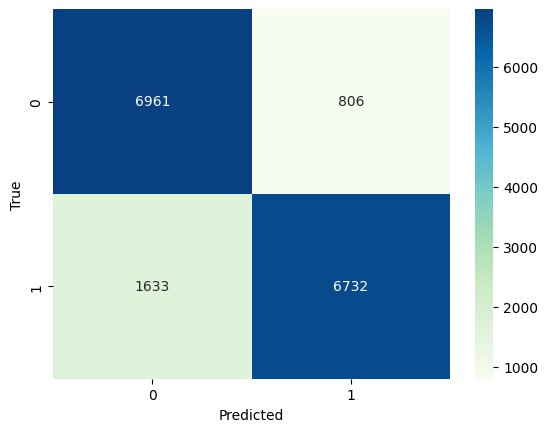

In [ ]:
matriz_de_confusion(y_test_voting, y_pred_voting)

Métricas en el conjunto de evaluación del ensamble hibrido voting

In [ ]:
metricas_evaluacion(y_test_voting, y_pred_voting)

Accuracy: 0.8488098189933052
Recall: 0.8047818290496115
f1 score: 0.8466327108092813


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de test del  ensamble hibrido voting

In [ ]:
valor_metricas_test(y_test_voting, y_pred_voting)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      7767
           1       0.89      0.80      0.85      8365

    accuracy                           0.85     16132
   macro avg       0.85      0.85      0.85     16132
weighted avg       0.85      0.85      0.85     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de train del ensamble hibrido voting

In [ ]:
valor_metricas_train(y_train_voting, x_train_voting, model_voting)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.87      0.97      0.92     17963
           1       0.97      0.87      0.92     19676

    accuracy                           0.92     37639
   macro avg       0.92      0.92      0.92     37639
weighted avg       0.92      0.92      0.92     37639



Viendo el valor de las metricas para ambos casos, y con la matriz de confusion, podemos concluir que entre los label 0 y 1, hay diferencia significativa entre
el recall y el precision.

Tambien, en ambos casos, el label 1 es aquel que tiene mayor valor para precision y f1-score y coincide con la mayor cantidad de registros con este label. Y tambien, coincide que ambos tienen para el label 0, el recall mas alto.

Por ultimo, como podemos ver, la diferencia del f1-score en ambos casos no es tan grande, pero consideramos que no afecta al entrenamiento del modelo y por eso no esta overfiteado.

## **Ensamble Hibrido Stacking**

Matriz de confusion del modelo ensamble hibrido Stacking

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


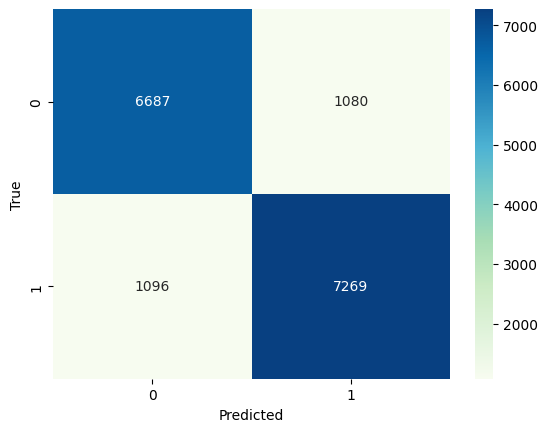

In [ ]:
matriz_de_confusion(y_test_stacking, y_pred_stacking)

Métricas en el conjunto de evaluación del modelo ensamble hibrido Stacking

In [ ]:
metricas_evaluacion(y_test_stacking, y_pred_stacking)

Accuracy: 0.8651128192412596
Recall: 0.8689778840406456
f1 score: 0.8698097403374417


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de test del modelo ensamble hibrido stacking

In [ ]:
valor_metricas_test(y_test_stacking, y_pred_stacking)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7767
           1       0.87      0.87      0.87      8365

    accuracy                           0.87     16132
   macro avg       0.86      0.86      0.86     16132
weighted avg       0.87      0.87      0.87     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metricas de train del modelo ensamble hibrido stacking

In [ ]:
valor_metricas_train(y_train_stacking, x_train_stacking, stacking_model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17963
           1       1.00      1.00      1.00     19676

    accuracy                           1.00     37639
   macro avg       1.00      1.00      1.00     37639
weighted avg       1.00      1.00      1.00     37639



Viendo el valor de ambas metricas, y con la matriz de confusion, podemos decir que entre los labels 0 y 1, no hay diferencia significativa, pero si difieren entre ambos casos.

Tambien podemos ver que en ambos casos, en el label 1, las metricas tienen el mismo valor y coincide con la mayor cantidad de registros del label.

Por ultimo, como podemos observar, el f1-score en datos de entrenamiento es aproximadamente un 15% mas alto que con datos de test, esto indica que el modelo podria estar overfiteado

# **Submission y exportación del modelo entrenado**

Exportamos cada modelo con mejor performance, sacamos la prediccion con el dataset Test y posteriormente, guardamos la submission para la subida a Kaggle.

## **KNN**

In [ ]:
import joblib

joblib.dump(model_knn, '/content/drive/MyDrive/TP1_Orga/clasificador_knn.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/content/drive/MyDrive/TP1_Orga/clasificador_knn.joblib']

In [ ]:
y_pred_knn_submission = model_knn.predict(ds_test)

df_submission_knn = pd.DataFrame({'id': ds_test_id, target: y_pred_knn_submission})

df_submission_knn.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_ensamble_KNN.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **SVM**

In [ ]:
import joblib

joblib.dump(svm_model_pc, '/content/drive/MyDrive/TP1_Orga/clasificador_svm.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/content/drive/MyDrive/TP1_Orga/clasificador_svm.joblib']

In [ ]:
y_pred_svm_submission = svm_model_pc.predict(ds_test)

df_submission_svm = pd.DataFrame({'id': ds_test_id, target: y_pred_svm_submission})

df_submission_svm.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_ensamble_SVM.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **RF**

In [ ]:
import joblib

joblib.dump(mejor_modelo_rf, '/content/drive/MyDrive/TP1_Orga/clasificador_rf.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/content/drive/MyDrive/TP1_Orga/clasificador_rf.joblib']

In [ ]:
y_pred_rf_submission = mejor_modelo_rf.predict(ds_test)

df_submission_rf = pd.DataFrame({'id': ds_test_id, target: y_pred_rf_submission})

df_submission_rf.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_ensamble_RF.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **XGBoost**


In [ ]:
import joblib

joblib.dump(xgb_model, '/content/drive/MyDrive/TP1_Orga/clasificador_xgb.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/content/drive/MyDrive/TP1_Orga/clasificador_xgb.joblib']

In [ ]:
y_pred_xgb_submission = xgb_model.predict(ds_test)

df_submission_xgb = pd.DataFrame({'id': ds_test_id, target: y_pred_xgb_submission})

df_submission_xgb.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_ensamble_XGB.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Ensamble hibrido Voting**

In [ ]:
import joblib

joblib.dump(model_voting, '/content/drive/MyDrive/TP1_Orga/clasificador_voting.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/content/drive/MyDrive/TP1_Orga/clasificador_voting.joblib']

In [ ]:
y_pred_voting_submission = model_voting.predict(ds_test)

df_submission_voting = pd.DataFrame({'id': ds_test_id, target: y_pred_voting_submission})

df_submission_voting.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_ensamble_VOT.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Ensamble hibrido Stacking**



In [ ]:
import joblib

joblib.dump(stacking_model, '/content/drive/MyDrive/TP1_Orga/clasificador_stacking.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/content/drive/MyDrive/TP1_Orga/clasificador_stacking.joblib']

In [ ]:
y_pred_stacking_submission = stacking_model.predict(ds_test)

df_submission_stacking = pd.DataFrame({'id': ds_test_id, target: y_pred_stacking_submission})

df_submission_stacking.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_ensamble_STACK.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
